In [1]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 49 (delta 6), reused 30 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 2.02 MiB | 2.09 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Already up to date.


In [2]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-zwu07w87


In [3]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [4]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'Mixer-B_16'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://mixer_models/imagenet21k/Mixer-B_16.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

\ [1 files][289.6 MiB/289.6 MiB]   22.6 MiB/s                                   
Operation completed over 1 objects/289.6 MiB.                                    


In [5]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [6]:

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to [0, 1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print the shape of the dataset
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

# Define the number of classes
num_classes = 10

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [7]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[cuda(id=0)]

In [8]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

INFO:absl:Created `ArrayHandler` with primary_host=0, replica_id=0


In [10]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [11]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

In [12]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
del config  # Only needed to instantiate datasets.

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpwjxn1tontfds
INFO:absl:For 'cifar10/3.0.2': fields info.[citation, splits, supervised_keys, module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.c0e0781816554f8caf2a54c34885e6e6...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.39K3G4_3.0.2/cifar10-train.tfrecord*...:   0%|         …

INFO:absl:Done writing /root/tensorflow_datasets/cifar10/incomplete.39K3G4_3.0.2/cifar10-train.tfrecord*. Number of examples: 50000 (shards: [50000])


Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.39K3G4_3.0.2/cifar10-test.tfrecord*...:   0%|          …

INFO:absl:Done writing /root/tensorflow_datasets/cifar10/incomplete.39K3G4_3.0.2/cifar10-test.tfrecord*. Number of examples: 10000 (shards: [10000])
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


In [13]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(1, 512, 224, 224, 3)

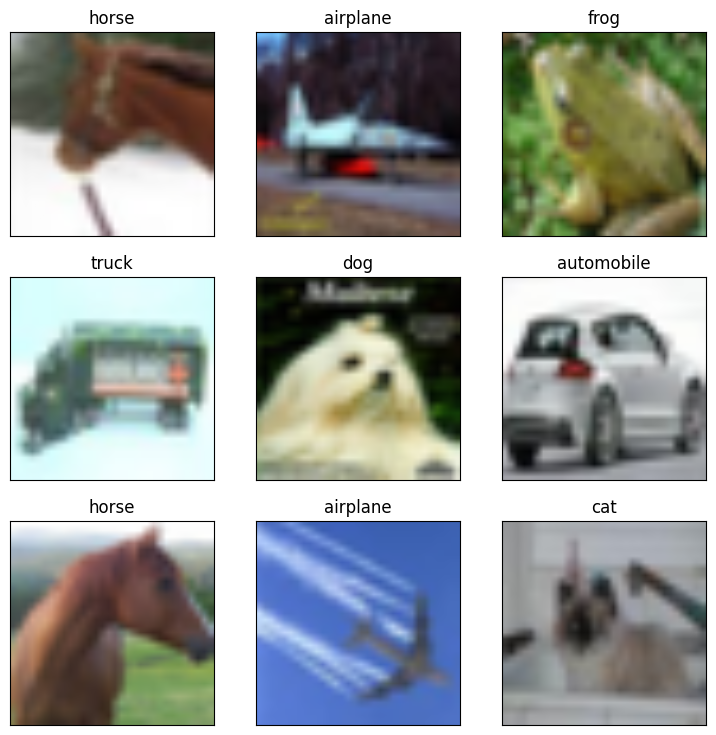

In [14]:
# Show some images with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

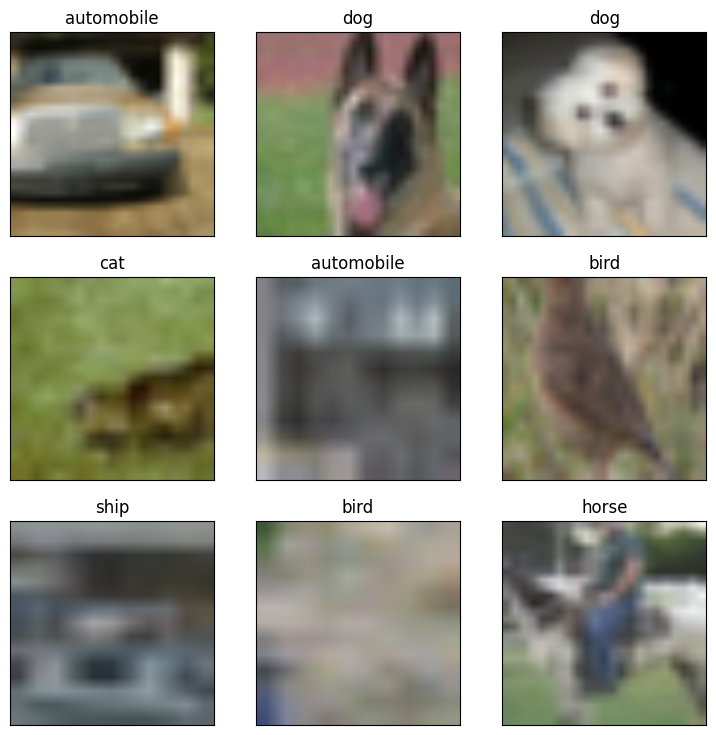

In [15]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [16]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

channels_mlp_dim: 3072
hidden_dim: 768
model_name: Mixer-B_16
num_blocks: 12
patches:
  size: !!python/tuple
  - 16
  - 16
tokens_mlp_dim: 384

In [17]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [18]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

### Evaluate

In [19]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (10,)
params_repl.cls: ArrayImpl (1, 10)


In [20]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [21]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [22]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:33<00:00,  4.93s/it]


Array(0.10063734, dtype=float32)

### Fine-tune

In [23]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [24]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [25]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [19:43<00:00, 11.84s/it]


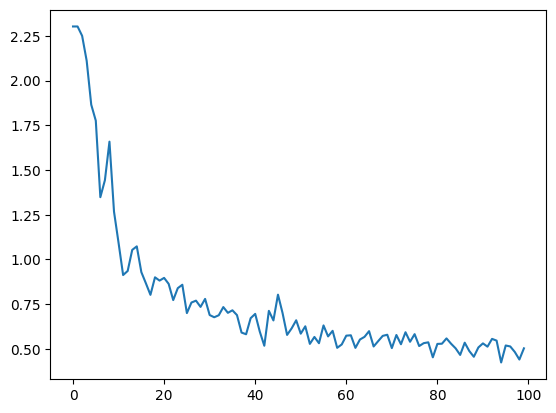

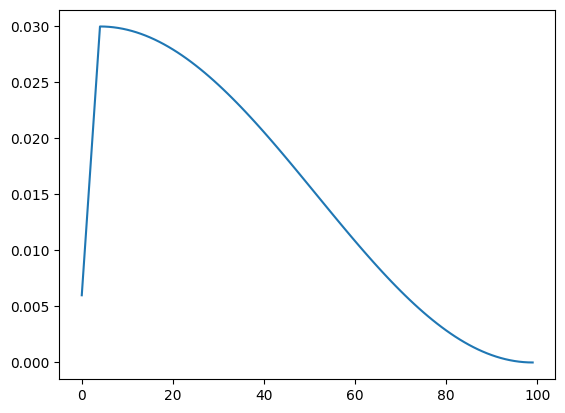

In [26]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [27]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [01:12<00:00,  3.79s/it]


Array(0.9643298, dtype=float32)

### Inference

In [28]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

Copying gs://mixer_models/imagenet1k/Mixer-B_16.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][228.5 MiB/228.5 MiB]   17.3 MiB/s                                   
Operation completed over 1 objects/228.5 MiB.                                    


In [29]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [30]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2024-08-14 04:04:31--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 64.233.170.207, 142.251.175.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2024-08-14 04:04:33 (137 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



--2024-08-14 04:04:33--  https://picsum.photos/224
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 172.67.74.163, 104.26.4.30, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastly.picsum.photos/id/622/224/224.jpg?hmac=QLa3KP_BB_orGiQe0G-A2grAoJdw-Ejn37YE5dzoiZk [following]
--2024-08-14 04:04:33--  https://fastly.picsum.photos/id/622/224/224.jpg?hmac=QLa3KP_BB_orGiQe0G-A2grAoJdw-Ejn37YE5dzoiZk
Resolving fastly.picsum.photos (fastly.picsum.photos)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to fastly.picsum.photos (fastly.picsum.photos)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7639 (7.5K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]   7.46K  --.-KB/s    in 0s      

2024-08-14 04:04:35 (45.2 MB/s) - ‘picsum.jpg’ saved [7639/7639]



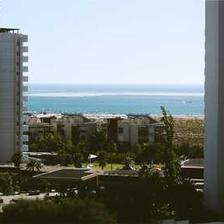

In [31]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [32]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [33]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.65759 : monitor
0.09044 : seashore, coast, seacoast, sea-coast
0.04769 : screen, CRT_screen
0.03522 : television, television_system
0.03314 : lakeside, lakeshore
0.01416 : bell_cote, bell_cot
0.01085 : planetarium
0.00870 : patio, terrace
0.00680 : desktop_computer
0.00655 : sliding_door


# Loading and Preprocessing the SVHN Dataset

In this section, we load and preprocess the SVHN (Street View House Numbers) dataset. This involves importing necessary libraries, defining a function to load the data, normalizing the images, and converting the labels to one-hot encoded format.

## 1. Importing Necessary Libraries
We begin by importing the required libraries:
- `tensorflow`: A library for building and training neural networks.
- `scipy.io`: For loading the SVHN dataset from .mat files.
- `tensorflow.keras.utils`: For converting class vectors to binary class matrices (one-hot encoding).
- `ml_collections`: For creating a configuration dictionary.

## 2. Function to Load SVHN Data
We define a function `load_svhn` to load the SVHN data from .mat files:
- The function reads the data from the specified path.
- The images are transposed to match the expected input shape for the neural network.
- Labels are adjusted to convert the label '10' to '0' as per the SVHN dataset conventions.

## 3. Load the SVHN Dataset
We load the training and testing data from the SVHN dataset using the `load_svhn` function:
- `x_train, y_train`: Training images and labels.
- `x_test, y_test`: Testing images and labels.

## 4. Normalize the Images
The images are normalized to a range of [0, 1] by dividing by 255.0. This normalization helps in speeding up the training process and achieving better performance.

## 5. Define the Number of Classes
We define the number of classes in the SVHN dataset. The SVHN dataset contains 10 classes (digits 0-9).

## 6. Convert Class Vectors to Binary Class Matrices
The labels are converted to binary class matrices (one-hot encoding) using `to_categorical`. This format is required for training the neural network:
- `y_train`: One-hot encoded training labels.
- `y_test`: One-hot encoded testing labels.

## 7. Print the Shape of the Dataset
We print the shapes of the training and testing datasets to ensure they have been loaded and preprocessed correctly:
- `x_train.shape`: Shape of the training images.
- `x_test.shape`: Shape of the testing images.


In [58]:
import tensorflow as tf
from scipy.io import loadmat
from tensorflow.keras.utils import to_categorical
from ml_collections import ConfigDict

# Function to load SVHN data from .mat files
def load_svhn(path, split='train'):
    data = loadmat(path)
    images = data['X']
    labels = data['y'].flatten()
    labels[labels == 10] = 0  # SVHN labels '10' as '0'
    images = images.transpose((3, 0, 1, 2))  # Move the last dimension to the front
    return images, labels

# Load the SVHN dataset (train and test)
x_train, y_train = load_svhn('train_32x32.mat', 'train')
x_test, y_test = load_svhn('test_32x32.mat', 'test')

# Normalize the images to [0, 1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define the number of classes
num_classes = 10

# Convert class vectors to binary class matrices (one-hot encoding)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Print the shape of the dataset
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')


Training data shape: (73257, 32, 32, 3)
Test data shape: (26032, 32, 32, 3)


# Configuration Setup for SVHN Dataset

In this section, we manually set up the configuration for the SVHN dataset using `ConfigDict` from the `ml_collections` library. This configuration will be used to define various parameters for preprocessing and model training.

## 1. Define the Configuration Dictionary
We initialize a `ConfigDict` object to store all the configuration parameters.

## 2. Dataset and Batch Size
- `config.dataset`: Specifies the dataset being used, which is 'svhn' in this case.
- `config.batch`: Defines the batch size for training the model. We set it to 512.

## 3. Input Shape
- `config.input_shape`: Specifies the shape of the input images. For the SVHN dataset, the images are 32x32 pixels with 3 color channels (RGB).

## 4. Number of Classes
- `config.num_classes`: Defines the number of classes in the dataset. The SVHN dataset has 10 classes (digits 0-9).

## 5. Preprocessing Parameters
We create a nested `ConfigDict` for preprocessing parameters:
- `config.pp.crop`: Specifies the crop size for the images. Since SVHN images are already 32x32 pixels, cropping is unnecessary and we retain the original size.

This configuration setup ensures that all necessary parameters are defined in a structured manner, making it easier to manage and update them as needed.


In [59]:
# Manually set up the configuration for SVHN
config = ConfigDict()

config.dataset = 'svhn'
config.batch = 512
config.input_shape = (32, 32, 3)  # SVHN images are 32x32 pixels with 3 channels
config.num_classes = 10

# Set preprocessing parameters
config.pp = ConfigDict()
config.pp.crop = 32  # SVHN images are already 32x32, so cropping is unnecessary

# Helper Functions for SVHN

In this section, we define helper functions to manage label names for the SVHN dataset and to create a label getter function.

## 1. Define Label Names
We create a dictionary `labelnames` that maps the dataset name to a tuple of label names. For the SVHN dataset, the labels are digits from '0' to '9':
- `labelnames`: Dictionary containing the label names for the SVHN dataset.

## 2. Function to Create Label Getter
We define a function `make_label_getter` that returns another function to convert label indices to label names:
- The `make_label_getter` function takes the dataset name as input and returns a `getter` function.
- The `getter` function takes a label index as input and returns the corresponding label name if the dataset is in the `labelnames` dictionary. If not, it returns a default string `label={label}`.

This setup helps in converting numeric label indices to human-readable label names, making it easier to interpret the model's predictions.


In [60]:
# Helper functions for SVHN
labelnames = dict(
  svhn=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'),  # SVHN has digit labels 0-9
)

def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

# Visualization Functions for SVHN Dataset

In this section, we define helper functions to visualize images from the SVHN dataset. These functions use Matplotlib to display single images and grids of images.

## 1. Importing Necessary Libraries
We import the required libraries for visualization:
- `matplotlib.pyplot`: For plotting images.
- `numpy`: For numerical operations.

## 2. Function to Show a Single Image
We define the `show_img` function to display a single image:
- `img`: The image to be displayed.
- `ax`: The axis on which to display the image. If not provided, it uses the current axis (`plt.gca()`).
- `title`: Optional title for the image.
- The function hides the axis ticks and sets the title if provided.

## 3. Function to Show a Grid of Images
We define the `show_img_grid` function to display a grid of images:
- `imgs`: A list of images to be displayed in a grid.
- `titles`: Optional list of titles for each image. If not provided, it defaults to empty titles.
- The function calculates the grid size `n` based on the number of images.
- It creates a grid of subplots using `plt.subplots`.
- It iterates over the images and titles, displaying each image in a subplot using the `show_img` function.
- Any remaining subplots (if the number of images is not a perfect square) are turned off.
- Finally, the function displays the grid using `plt.show()`.

These functions help in visualizing the images, making it easier to understand the dataset and the model's predictions.


In [56]:
import matplotlib.pyplot as plt
import numpy as np

def show_img(img, ax=None, title=None):
    """Shows a single image."""
    if ax is None:
        ax = plt.gca()
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title)

def show_img_grid(imgs, titles=None):
    """Shows a grid of images."""
    n = int(np.ceil(len(imgs)**0.5))
    fig, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
    axs = axs.flatten()
    for i, (img, title) in enumerate(zip(imgs, titles or ['']*len(imgs))):
        show_img(img, ax=axs[i], title=title)
    for ax in axs[len(imgs):]:
        ax.axis('off')
    plt.show()


### Display the First Image

This cell displays the first image from the `x_train` dataset. The `show_img` function is used to render the image, and the title "First Image" is set for the display.

```python
show_img(x_train[0], title="First Image")


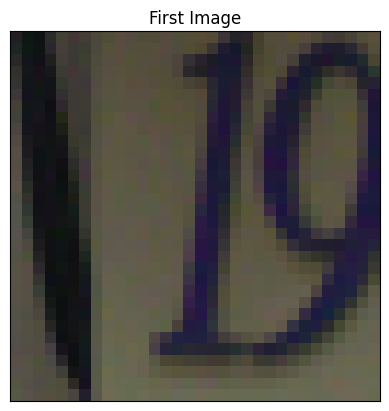

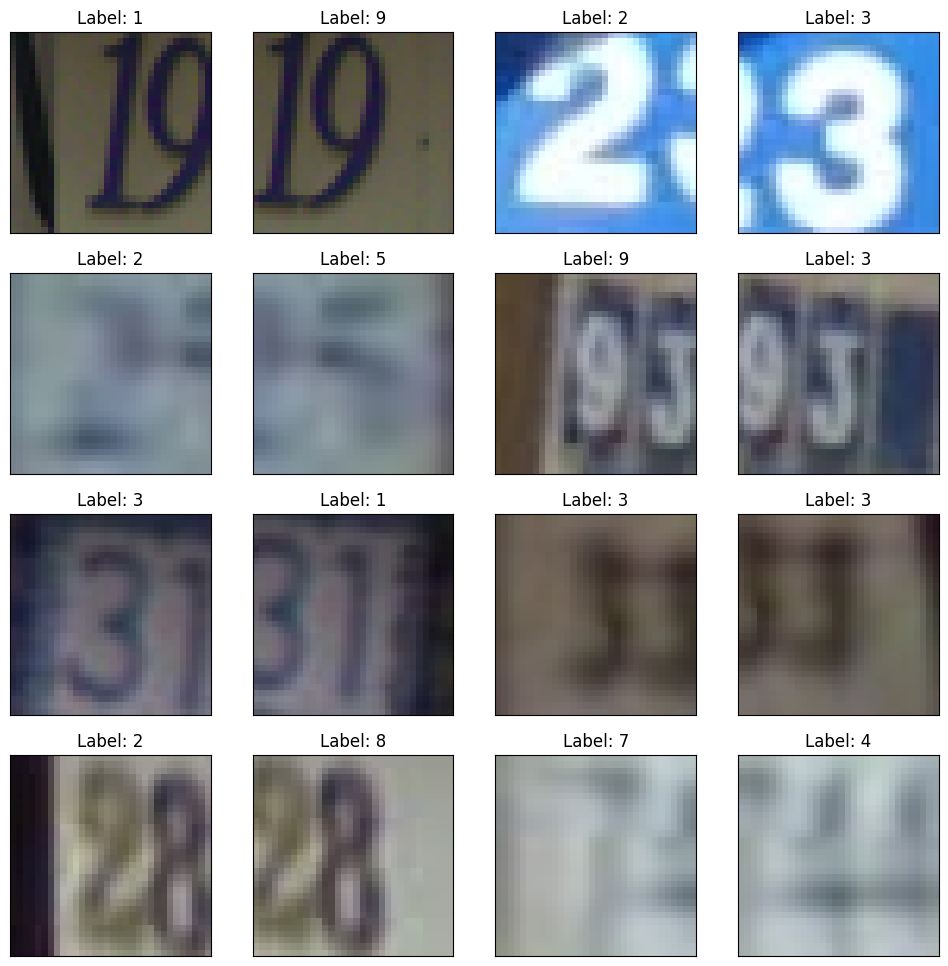

In [57]:
# Assuming x_train contains your SVHN images
# Display the first image in the training set
show_img(x_train[0], title="First Image")

# Display a grid of the first 16 images in the training set
show_img_grid(x_train[:16], titles=[f"Label: {np.argmax(y_train[i])}" for i in range(16)])
